# Hyperparameter Optimization Of TemporalFusionTransformer

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame

In [28]:
# Load data of closing transaction
df = pd.read_csv('../CSV/df_TS_week.csv')
df.head()

,item_id,timestamp,target,ACT01,ACT03,ACT04,ACT07,ACT09,ACT13,ACT15,ACT17,ACT32,ACT44
0,FR13,2019-12-30,7663.0,1267.0,299.0,0.0,2108.0,189.0,84.0,0.0,0.0,3716.0,0.0
1,FR13,2020-01-06,2917.0,1052.0,490.0,2.0,103.0,255.0,191.0,3.0,0.0,821.0,0.0
2,FR13,2020-01-13,2341.0,846.0,115.0,0.0,280.0,69.0,66.0,416.0,407.0,142.0,0.0
3,FR13,2020-01-20,3853.0,1350.0,932.0,44.0,568.0,297.0,278.0,81.0,80.0,223.0,0.0
4,FR13,2020-01-27,82251.0,1871.0,863.0,0.0,609.0,363.0,219.0,2.0,0.0,19393.0,58931.0


In [29]:
# Create a new df of the item_id equal to IT01 
df_IT = df[df['item_id'] == 'IT01']
print(df_IT.shape)

(172, 13)


In [30]:
# Drop ACT04 column
df_IT = df_IT.drop(columns=['ACT04'])

In [31]:
# Split data into training and testing set; train set based on timestamp from 2020-01-01 to 2022-04-30 and test set based on timestamp from 2022-05-01 to 2023-04-30
train_data = df_IT[df_IT['timestamp'] <= '2022-04-30']
test_data = df_IT[df_IT['timestamp'] > '2022-04-30']

# Calculate the percentage of the training set and testing set
print(train_data.shape[0] / df_IT.shape[0])
print(test_data.shape[0] / df_IT.shape[0])

0.6976744186046512
0.3023255813953488


In [32]:
# Convert train_data to TimeSeriesDataFrame
train_data = TimeSeriesDataFrame(
    train_data, 
    id_column="item_id",
    timestamp_column="timestamp"
    
)

train_data.head()

target   ACT01  ACT03  ACT07  ACT09  ACT13   ACT15  \
item_id timestamp                                                        
IT01    2019-12-30  7613.0  1228.0   87.0  195.0  188.0   32.0  1817.0   
        2020-01-06   390.0    87.0   63.0    5.0    8.0    0.0     0.0   
        2020-01-13   702.0   161.0   10.0   14.0    0.0   49.0     1.0   
        2020-01-20   941.0   437.0  143.0   86.0   67.0  110.0     0.0   
        2020-01-27  1470.0   403.0  457.0  178.0  108.0   48.0     7.0   

                     ACT17   ACT32  ACT44  
item_id timestamp                          
IT01    2019-12-30  1255.0  2811.0    0.0  
        2020-01-06     0.0   227.0    0.0  
        2020-01-13     0.0   467.0    0.0  
        2020-01-20     0.0    98.0    0.0  
        2020-01-27     0.0   269.0    0.0

In [33]:
# Convert test_data to TimeSeriesDataFrame
test_data = TimeSeriesDataFrame(
    test_data, 
    id_column="item_id",
    timestamp_column="timestamp"
    
)

test_data.head()

target  ACT01  ACT03  ACT07  ACT09  ACT13  ACT15  ACT17  \
item_id timestamp                                                             
IT01    2022-05-02  4074.0  788.0   29.0  396.0   30.0  111.0  515.0  145.0   
        2022-05-09   756.0  137.0    0.0  124.0    0.0    0.0    0.0    0.0   
        2022-05-16   439.0  153.0   27.0   76.0    2.0   24.0    0.0    0.0   
        2022-05-23  2078.0  452.0   28.0  387.0   57.0  158.0  506.0  138.0   
        2022-05-30  3883.0  912.0  198.0  514.0  178.0  261.0   14.0   10.0   

                     ACT32  ACT44  
item_id timestamp                  
IT01    2022-05-02  2060.0    0.0  
        2022-05-09   495.0    0.0  
        2022-05-16   157.0    0.0  
        2022-05-23   352.0    0.0  
        2022-05-30  1796.0    0.0

In [34]:
# Build predictor
predictor = TimeSeriesPredictor(
    prediction_length=12,
    freq='W-MON',
    target='target',
    path='C:\\Develop\\HPO\\TemporalFusionTransformer_Final',
    eval_metric='MASE'
)

In [35]:
from autogluon.common import space
from autogluon.common.utils.log_utils import add_log_to_file
from autogluon.timeseries.predictor import logger as LG

add_log_to_file("C:\\Develop\\HPO\\final.log", LG)

# Fit the model
predictor.fit(
    train_data,
    hyperparameters = {
        "TemporalFusionTransformer": { 
           "hidden_dim": 32,  
           "variable_dim": 128,
           "num_heads": 4,
           "dropout_rate": space.Real(0.1, 0.3),
           "max_epochs": 100,
           "batch_size": 64,
           "lr": space.Categorical(0.1, 0.01, 0.001),
           "early_stopping_patience" : 10
        },
    },
    hyperparameter_tune_kwargs="auto",
    refit_full=True,
    num_val_windows=5,
    random_seed=42,
)

LG.info(
        predictor.leaderboard()
)

	Trained 10 models while tuning TemporalFusionTransformer.
	-0.5024       = Validation score (-MASE)
	18207.47 s    = Total tuning time
Fitting simple weighted ensemble.
	Ensemble weights: {'TemporalFusionTransformer\\05c5e857': 0.13, 'TemporalFusionTransformer\\69bdc396': 0.12, 'TemporalFusionTransformer\\735a71a3': 0.57, 'TemporalFusionTransformer\\c3fe6316': 0.18}
	-0.4576       = Validation score (-MASE)
	6.13    s     = Training runtime
	0.33    s     = Validation (prediction) runtime
Training complete. Models trained: ['TemporalFusionTransformer\\e8902ab2', 'TemporalFusionTransformer\\4dbff75b', 'TemporalFusionTransformer\\12777465', 'TemporalFusionTransformer\\69bdc396', 'TemporalFusionTransformer\\42270e7b', 'TemporalFusionTransformer\\05c5e857', 'TemporalFusionTransformer\\c3fe6316', 'TemporalFusionTransformer\\c7b744ff', 'TemporalFusionTransformer\\735a71a3', 'TemporalFusionTransformer\\0bc2a5d6', 'WeightedEnsemble']
Total runtime: 18214.67 s
Best model: WeightedEnsemble
Best

In [36]:
# Make prediction on training data
predictions = predictor.predict(train_data, random_seed=42)
predictions.head()

data with frequency 'None' has been resampled to frequency 'W-MON'.
data contains missing values represented by NaN. They have been filled by carrying forward the last valid observation.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble_FULL


mean          0.1          0.2          0.3  \
item_id timestamp                                                        
IT01    2022-05-02  3974.627441  3532.640625  3770.748047  3794.520996   
        2022-05-09  1549.939209   916.013428  1108.415527  1296.315918   
        2022-05-16   849.896484   316.583130   475.097870   622.456787   
        2022-05-23  1451.493530   982.312378  1147.999878  1284.977417   
        2022-05-30  4027.775635  3510.899414  3744.688477  3838.019775   

                            0.4          0.5          0.6          0.7  \
item_id timestamp                                                        
IT01    2022-05-02  3886.963867  3974.627441  4106.276367  4304.752930   
        2022-05-09  1401.136597  1549.939209  1682.206909  1873.440308   
        2022-05-16   718.902100   849.896484   981.476929  1149.262207   
        2022-05-23  1365.066650  1451.493530  1575.016602  1733.958740   
        2022-05-30  3926.181152  4027.775635  4213.367188  4410.172363   

                            0.8          0.9  
item_id timestamp                             
IT01    2022-05-02  4483.598633  4901.357910  
        2022-05-09  2181.313721  2452.412109  
        2022-05-16  1354.549561  1511.462891  
        2022-05-23  1849.008911  2049.293945  
        2022-05-30  4555.666504  4896.433594

In [37]:
predictor.leaderboard(test_data)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,TemporalFusionTransformer\e8902ab2_FULL,-0.167590,NaN,0.098751,NaN,2108.805242,12
1,TemporalFusionTransformer\e8902ab2,-0.167590,-0.640682,0.069608,0.046892,16442.386269,1
2,TemporalFusionTransformer\735a71a3_FULL,-0.203739,NaN,0.067658,NaN,1731.394438,20
3,TemporalFusionTransformer\735a71a3,-0.203739,-0.502440,0.062460,0.062930,6072.026896,9
4,TemporalFusionTransformer\42270e7b_FULL,-0.210926,NaN,0.076615,NaN,2531.169759,16
5,TemporalFusionTransformer\42270e7b,-0.210926,-0.541692,0.064733,0.037560,18161.498506,5
6,TemporalFusionTransformer\c3fe6316_FULL,-0.219672,NaN,0.057585,NaN,1799.113963,18
7,TemporalFusionTransformer\c3fe6316,-0.219672,-0.538540,0.058449,0.047975,7534.654666,7
8,WeightedEnsemble_FULL,-0.225046,NaN,0.254424,NaN,6.130205,22
9,WeightedEnsemble,-0.225046,-0.457562,0.263203,0.325200,6.130205,11


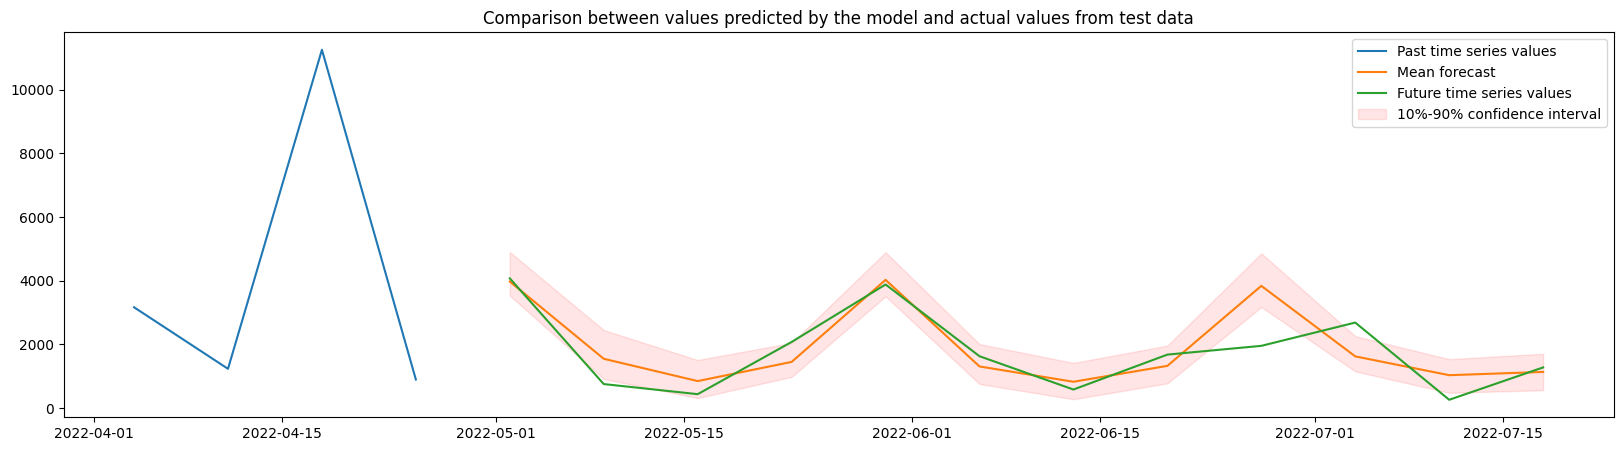

In [38]:
plt.figure(figsize=(20, 5))
plt.title("Comparison between values predicted by the model and actual values from test data")

item_id = "IT01"
y_past = train_data.loc[item_id]["target"]
y_pred = predictions.loc[item_id]
y_test = test_data.loc[item_id]["target"][:12]

plt.plot(y_past[-4:], label="Past time series values")
plt.plot(y_pred["mean"], label="Mean forecast")
plt.plot(y_test, label="Future time series values")

plt.fill_between(
    y_pred.index, y_pred["0.1"], y_pred["0.9"], color="red", alpha=0.1, label=f"10%-90% confidence interval"
)
plt.legend()

In [39]:
# Print all row of predictions where item_id is IT01
predictions.loc['IT01']

,mean,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
timestamp,,,,,,,,,,
2022-05-02,3974.627441,3532.640625,3770.748047,3794.520996,3886.963867,3974.627441,4106.276367,4304.752930,4483.598633,4901.357910
2022-05-09,1549.939209,916.013428,1108.415527,1296.315918,1401.136597,1549.939209,1682.206909,1873.440308,2181.313721,2452.412109
2022-05-16,849.896484,316.583130,475.097870,622.456787,718.902100,849.896484,981.476929,1149.262207,1354.549561,1511.462891
2022-05-23,1451.493530,982.312378,1147.999878,1284.977417,1365.066650,1451.493530,1575.016602,1733.958740,1849.008911,2049.293945
2022-05-30,4027.775635,3510.899414,3744.688477,3838.019775,3926.181152,4027.775635,4213.367188,4410.172363,4555.666504,4896.433594
2022-06-06,1309.123047,758.317017,884.797180,1072.529541,1199.090210,1309.123047,1465.371338,1570.949097,1743.504517,2012.275146
2022-06-13,828.513672,280.487671,499.218079,637.167847,694.995361,828.513672,975.457886,1112.563110,1289.239746,1420.406616
2022-06-20,1327.439453,779.132751,996.115479,1139.635864,1217.573608,1327.439453,1460.227051,1590.320801,1756.327148,1964.467285
2022-06-27,3839.711914,3173.649658,3532.293457,3617.982178,3783.419434,3839.711914,4020.317139,4242.480469,4445.517578,4859.707520


In [40]:
# Sum all value of mean forecast of predictions where item_id is IT01
predictions.loc['IT01']['mean'].sum()

22956.258

In [41]:
# Sum all value of target of test_data 
test_data.loc['IT01']['target'][:12].sum()

21311.0

In [42]:
# Calculate difference betweend each prediction and actual value of test_data
diff = predictions.loc['IT01']['mean'] - test_data.loc['IT01']['target'][:12]
diff

timestamp
2022-05-02     -99.372559
2022-05-09     793.939209
2022-05-16     410.896484
2022-05-23    -626.506470
2022-05-30     144.775635
2022-06-06    -320.876953
2022-06-13     243.513672
2022-06-20    -353.560547
2022-06-27    1883.711914
2022-07-04   -1061.296387
2022-07-11     771.772827
2022-07-18    -141.738647
dtype: float64

In [43]:
# Show model names
predictor.model_names()

['TemporalFusionTransformer\\e8902ab2',
 'TemporalFusionTransformer\\4dbff75b',
 'TemporalFusionTransformer\\12777465',
 'TemporalFusionTransformer\\69bdc396',
 'TemporalFusionTransformer\\42270e7b',
 'TemporalFusionTransformer\\05c5e857',
 'TemporalFusionTransformer\\c3fe6316',
 'TemporalFusionTransformer\\c7b744ff',
 'TemporalFusionTransformer\\735a71a3',
 'TemporalFusionTransformer\\0bc2a5d6',
 'WeightedEnsemble',
 'TemporalFusionTransformer\\e8902ab2_FULL',
 'TemporalFusionTransformer\\4dbff75b_FULL',
 'TemporalFusionTransformer\\12777465_FULL',
 'TemporalFusionTransformer\\69bdc396_FULL',
 'TemporalFusionTransformer\\42270e7b_FULL',
 'TemporalFusionTransformer\\05c5e857_FULL',
 'TemporalFusionTransformer\\c3fe6316_FULL',
 'TemporalFusionTransformer\\c7b744ff_FULL',
 'TemporalFusionTransformer\\735a71a3_FULL',
 'TemporalFusionTransformer\\0bc2a5d6_FULL',
 'WeightedEnsemble_FULL']

In [45]:
# Show parameters of the model
model = predictor._trainer.load_model("TemporalFusionTransformer\\05c5e857")  # provide the model name here
model.get_user_params()

{'hidden_dim': 32,
 'variable_dim': 128,
 'num_heads': 4,
 'dropout_rate': 0.22220394653627767,
 'max_epochs': 100,
 'batch_size': 64,
 'lr': 0.001,
 'early_stopping_patience': 10}

In [46]:
# Show parameters of the model
model = predictor._trainer.load_model("TemporalFusionTransformer\\69bdc396")  # provide the model name here
model.get_user_params()

{'hidden_dim': 32,
 'variable_dim': 128,
 'num_heads': 4,
 'dropout_rate': 0.2363602548839217,
 'max_epochs': 100,
 'batch_size': 64,
 'lr': 0.1,
 'early_stopping_patience': 10}

In [47]:
# Show parameters of the model
model = predictor._trainer.load_model("TemporalFusionTransformer\\735a71a3")  # provide the model name here
model.get_user_params()

{'hidden_dim': 32,
 'variable_dim': 128,
 'num_heads': 4,
 'dropout_rate': 0.13512287666216133,
 'max_epochs': 100,
 'batch_size': 64,
 'lr': 0.01,
 'early_stopping_patience': 10}

In [48]:
# Show parameters of the model
model = predictor._trainer.load_model("TemporalFusionTransformer\\c3fe6316")  # provide the model name here
model.get_user_params()

{'hidden_dim': 32,
 'variable_dim': 128,
 'num_heads': 4,
 'dropout_rate': 0.14628010222764137,
 'max_epochs': 100,
 'batch_size': 64,
 'lr': 0.001,
 'early_stopping_patience': 10}